In [384]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from typing import Tuple
import optuna


In [385]:
sns.set_theme(style='whitegrid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Leitura e pré-processamento de dados.

In [386]:
df = pd.read_csv('data/Florida NREL 2023.csv', skiprows=2)
df.head(10)

,Year,Month,Day,Hour,Minute,Temperature,Alpha,Aerosol Optical Depth,Asymmetry,Clearsky DHI,...,GHI,Ozone,Relative Humidity,Solar Zenith Angle,SSA,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed
0,2020,1,1,0,30,12.8,1.43,0.052,0.65,0,...,0,0.249,78.01,113.56,0.92,0.16,1015,1.8,294,1.3
1,2020,1,1,1,30,11.9,1.44,0.048,0.65,0,...,0,0.250,79.01,126.47,0.92,0.16,1015,1.8,294,1.4
2,2020,1,1,2,30,11.3,1.44,0.045,0.65,0,...,0,0.252,79.58,139.58,0.91,0.16,1015,1.8,296,1.4
3,2020,1,1,3,30,10.8,1.43,0.045,0.65,0,...,0,0.252,80.53,152.75,0.92,0.16,1015,1.9,299,1.4
4,2020,1,1,4,30,10.6,1.42,0.046,0.65,0,...,0,0.252,80.77,165.68,0.92,0.16,1015,2.1,302,1.5
5,2020,1,1,5,30,10.6,1.40,0.052,0.65,0,...,0,0.252,80.46,174.60,0.93,0.16,1015,2.2,308,1.6
6,2020,1,1,6,30,10.4,1.41,0.057,0.65,0,...,0,0.252,82.58,165.26,0.93,0.16,1015,2.2,315,1.6
7,2020,1,1,7,30,9.9,1.44,0.055,0.65,0,...,0,0.251,83.70,152.31,0.93,0.16,1014,2.0,323,1.4
8,2020,1,1,8,30,9.4,1.45,0.051,0.65,0,...,0,0.252,85.26,139.13,0.93,0.16,1014,1.9,328,1.4
9,2020,1,1,9,30,9.1,1.45,0.048,0.65,0,...,0,0.252,85.85,126.02,0.92,0.16,1014,1.9,331,1.4


In [387]:
df.describe()

,Year,Month,Day,Hour,Minute,Temperature,Alpha,Aerosol Optical Depth,Asymmetry,Clearsky DHI,...,GHI,Ozone,Relative Humidity,Solar Zenith Angle,SSA,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.0,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,...,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,2018.528767,6.526027,15.720548,11.500000,30.0,22.692717,1.102733,0.135265,0.632521,51.734132,...,208.807648,0.281050,78.668935,89.730865,0.951562,0.163507,1014.182763,3.341918,163.444292,2.195936
std,3.162002,3.448048,8.796749,6.922582,0.0,6.079356,0.331841,0.079028,0.010915,61.105112,...,290.457856,0.020168,18.847688,41.624641,0.021697,0.009113,4.064898,1.435814,97.836396,1.263986
min,2014.000000,1.000000,1.000000,0.000000,30.0,-0.600000,0.140000,0.021000,0.620000,0.000000,...,0.000000,0.217000,19.010000,5.030000,0.870000,0.140000,1002.000000,0.400000,0.000000,0.200000
25%,2016.000000,4.000000,8.000000,5.750000,30.0,19.000000,0.880000,0.083000,0.620000,0.000000,...,0.000000,0.268000,64.670000,54.382500,0.940000,0.160000,1012.000000,2.200000,83.000000,1.200000
50%,2020.000000,7.000000,16.000000,11.500000,30.0,23.800000,1.170000,0.118000,0.630000,6.000000,...,5.000000,0.281000,82.805000,89.840000,0.960000,0.160000,1014.000000,3.300000,149.000000,1.900000
75%,2021.000000,10.000000,23.000000,17.250000,30.0,27.100000,1.350000,0.166000,0.640000,102.000000,...,399.250000,0.293000,96.122500,125.402500,0.970000,0.170000,1016.000000,4.600000,242.000000,3.000000
max,2023.000000,12.000000,31.000000,23.000000,30.0,35.500000,1.880000,0.736000,0.650000,331.000000,...,1076.000000,0.343000,100.000000,174.850000,0.990000,0.180000,1029.000000,6.900000,360.000000,7.400000


In [388]:
df['Year'].unique()

array([2020, 2014, 2021, 2022, 2017, 2023, 2016])

O banco de dados contém informações para os anos de 2014, 2016, 2017, 2020, 2021, 2022, 2023.

In [389]:
def data_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(['Minute','Cloud Type', 'Ozone','Solar Zenith Angle', 'Surface Albedo',
                    'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'DHI', 'DNI', 'Fill Flag', 'Cloud Fill Flag', 'Aerosol Optical Depth','Alpha','SSA','Asymmetry'], axis = 1)
    df = df.dropna()
    # Combine year, month, day, hour into a single datetime column
    df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])
    # Extract useful time-based features
    df['DayOfYear'] = df['Datetime'].dt.dayofyear
    df['HourOfDay'] = df['Datetime'].dt.hour
    df['Month'] = df['Datetime'].dt.month
    # Optionally, drop original columns if not needed
    df = df.drop(['Month', 'Day', 'Hour', 'Datetime'], axis=1)
    return df

In [390]:
def data_scaling_split(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    scaler = MinMaxScaler()
    columns_to_scale = [col for col in df.columns if col not in ['Year', 'DayOfYear', 'HourOfDay']]
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    # Uso dos dados até 2021 para treino, 2022 para validação e 2023 para teste.
    df_train = df[df['Year'] <= 2021]
    df_val = df[df['Year'] == 2022]
    df_test = df[df['Year'] == 2023]
    #Remove a coluna 'Year' dos dataframes.
    df_train = df_train.drop(['Year'], axis=1)
    df_val = df_val.drop(['Year'], axis=1)
    df_test = df_test.drop(['Year'], axis=1)
    # Reset index for both dataframes
    df_train.reset_index(drop=True, inplace=True)
    df_val.reset_index(drop=True, inplace=True)
    return df_train, df_val, df_test

In [391]:
df = data_preprocessing(df)
df.tail(10)

,Year,Temperature,Dew Point,GHI,Relative Humidity,Pressure,Precipitable Water,Wind Direction,Wind Speed,DayOfYear,HourOfDay
8750,2016,16.7,6.3,385,50.32,1021,1.4,108,2.7,366,14
8751,2016,20.3,8.7,535,47.38,1020,1.6,131,3.7,366,15
8752,2016,22.2,9.6,631,44.78,1019,1.7,141,3.6,366,16
8753,2016,23.3,9.9,660,42.76,1018,1.9,147,3.3,366,17
8754,2016,23.8,9.9,622,41.37,1017,2.0,151,3.2,366,18
8755,2016,23.8,9.8,521,41.00,1016,2.1,152,3.2,366,19
8756,2016,23.2,9.8,367,42.57,1016,2.2,151,2.8,366,20
8757,2016,20.6,10.4,179,52.12,1016,2.2,145,1.9,366,21
8758,2016,17.9,10.8,10,63.11,1017,2.2,138,1.3,366,22
8759,2016,16.8,11.1,0,69.18,1017,2.2,136,1.2,366,23


In [392]:
np.random.seed(42)  # For reproducibility
random_day = np.random.randint(1, 366)
df_random_day = df[df['DayOfYear'] == random_day]
df_random_day = df_random_day.drop(['DayOfYear'], axis=1)
year_of_day = df_random_day["Year"].iloc[0]

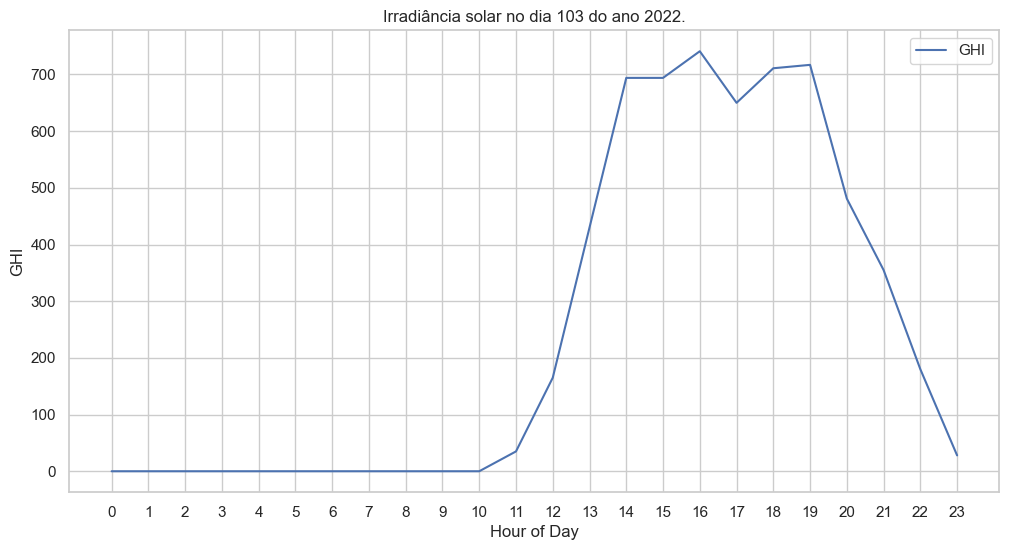

In [393]:
df_random_day.plot(
	x='HourOfDay',
	y='GHI',
	figsize=(12, 6),
	title=f'Irradiância solar no dia {random_day} do ano {year_of_day}.'
)
plt.xlabel('Hour of Day')
plt.ylabel('GHI')
plt.xticks(df_random_day['HourOfDay'])
plt.show()

In [394]:
df_train, df_val, df_test = data_scaling_split(df)


In [395]:
df_test

,Temperature,Dew Point,GHI,Relative Humidity,Pressure,Precipitable Water,Wind Direction,Wind Speed,DayOfYear,HourOfDay
6552,0.731302,0.946176,0.000000,0.998765,0.370370,0.830769,0.147222,0.361111,274,0
6553,0.725762,0.940510,0.000000,1.000000,0.370370,0.815385,0.150000,0.333333,274,1
6554,0.720222,0.934844,0.000000,1.000000,0.370370,0.800000,0.152778,0.305556,274,2
6555,0.717452,0.932011,0.000000,1.000000,0.370370,0.800000,0.152778,0.277778,274,3
6556,0.714681,0.929178,0.000000,1.000000,0.370370,0.800000,0.152778,0.263889,274,4
...,...,...,...,...,...,...,...,...,...,...
7291,0.853186,0.674221,0.534387,0.295345,0.111111,0.400000,0.019444,0.347222,304,19
7292,0.833795,0.660057,0.371747,0.298061,0.111111,0.400000,0.030556,0.333333,304,20
7293,0.783934,0.662890,0.184015,0.363749,0.148148,0.384615,0.058333,0.250000,304,21
7294,0.709141,0.696884,0.018587,0.522534,0.148148,0.369231,0.097222,0.180556,304,22


# Definição dos modelos.

In [396]:
class SimpleGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleGRU, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Camada GRU
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        
        # Camada de saída
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden=None):
        # Se hidden não for fornecido, inicializa com zeros
        if hidden is None:
            hidden = self.init_hidden(x.size(0))
        
        # Passa pela GRU
        out, hidden = self.gru(x, hidden)
        
        # Aplica a camada linear apenas na última saída temporal
        out = self.fc(out[:, -1, :])  # Pega apenas o último timestep
        
        return out
    
    def init_hidden(self, batch_size):
        # Inicializa o estado oculto com zeros
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

In [397]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.2, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers=num_layers,
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Camadas de regularização
        self.dropout1 = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout2 = nn.Dropout(dropout * 0.5)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        
        # Inicialização dos pesos
        self.init_weights()
        
    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        lstm_out, _ = self.lstm(x)
        
        # Pega apenas a última saída da sequência
        out = lstm_out[:, -1, :]
        
        # Regularização e camadas densas
        out = self.dropout1(out)
        out = self.batch_norm(out)
        out = torch.relu(self.fc1(out))
        out = self.dropout2(out)
        out = self.fc2(out)
        
        return out

In [398]:
#Modelo GRU
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.2, num_layers=1):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(
            input_size, 
            hidden_size, 
            num_layers=num_layers,
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Camadas de regularização
        self.dropout1 = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout2 = nn.Dropout(dropout * 0.5)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        
        # Inicialização dos pesos
        self.init_weights()
        
    def init_weights(self):
        for name, param in self.gru.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        gru_out, _ = self.gru(x)
        
        # Pega apenas a última saída da sequência
        out = gru_out[:, -1, :]
        
        # Regularização e camadas densas
        out = self.dropout1(out)
        out = self.batch_norm(out)
        out = torch.relu(self.fc1(out))
        out = self.dropout2(out)
        out = self.fc2(out)
        
        return out

# Função para treinamento do modelo.

In [399]:
def train_model(model, train_loader, test_loader, epochs, lr, patience=15, weight_decay=1e-5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.5)

    best_test_loss = float('inf')
    patience_counter = 0
    train_losses = []
    test_losses = []
    best_model_state = None

    for epoch in range(epochs):
        # Treino
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze(-1)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()

        # Teste
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                test_loss += criterion(outputs.squeeze(), y_batch).item()

        train_loss /= len(train_loader)
        test_loss /= len(test_loader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        scheduler.step(test_loss)

        # Early stopping baseado no teste
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping na época {epoch+1}")
                break

        if (epoch + 1) % 20 == 0:
            print(f'Época {epoch+1}/{epochs}: Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return train_losses, test_losses, best_test_loss


# Função para otimizar os hiperparâmetros

In [400]:
# Otimizar os hiperparâmetros com o optuna


def objective_GRU(trial, input_size, output_size, train_loader, test_loader):
    hidden_size = trial.suggest_int('hidden_size', 5, 25)
    num_layers = trial.suggest_int('num_layers', 1, 2)

    # Instantiate a new model with suggested hyperparameters
    model = SimpleGRU(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers).to(device)

    train_losses, test_losses, best_test_loss = train_model(
        model, train_loader, test_loader,
        epochs=100,
        lr=trial.suggest_loguniform('lr', 1e-5, 1e-2),
        weight_decay=trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
    )

    return best_test_loss

def optimize_hyperparameters_GRU(train_loader, test_loader, input_size, output_size, n_trials=50):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective_GRU(trial, input_size, output_size, train_loader, test_loader), n_trials=n_trials)

    print("Best hyperparameters: ", study.best_params)
    print("Best validation loss: ", study.best_value)

    return study.best_params



# Função para plotar as perdas.

In [ ]:
def plot_losses(train_losses, test_losses):
    """Plota as perdas de treino e teste """
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(test_losses, label='Test Loss', color='green')
    plt.title('Losses durante o treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [402]:
#Convertendo os dados de treino, validação e teste para tensores PyTorch
ghi_values_train = torch.tensor(df_train['GHI'].values, dtype=torch.float32).unsqueeze(-1)
ghi_values_val = torch.tensor(df_val['GHI'].values, dtype=torch.float32).unsqueeze(-1)
ghi_values_test = torch.tensor(df_test['GHI'].values, dtype=torch.float32).unsqueeze(-1)

X_train = ghi_values_train[:-1].unsqueeze(1)  # shape: (N-1, 1, 1)
y_train = ghi_values_train[1:].squeeze(-1)          # shape: (N-1, 1)
X_val = ghi_values_val[:-1].unsqueeze(1)  # shape: (N-1, 1, 1)
y_val = ghi_values_val[1:].squeeze(-1)          # shape: (N-1, 1)
X_test = ghi_values_test[:-1].unsqueeze(1)  # shape: (N-1, 1, 1)
y_test = ghi_values_test[1:].squeeze(-1)          # shape: (N-1, 1)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


optimize_hyperparameters_GRU(train_loader, val_loader, input_size=X_train.shape[2], output_size=1, n_trials=10)

[I 2025-07-13 21:50:17,903] A new study created in memory with name: no-name-d8b74912-8853-492d-9fdc-1b2a094eea4c
C:\Users\Ric\AppData\Local\Temp\ipykernel_37852\56233404.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr=trial.suggest_loguniform('lr', 1e-5, 1e-2),
C:\Users\Ric\AppData\Local\Temp\ipykernel_37852\56233404.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)


Época 20/100: Train Loss: 0.011570, Test Loss: 0.014169
Época 40/100: Train Loss: 0.011546, Test Loss: 0.014032
Época 60/100: Train Loss: 0.011525, Test Loss: 0.014043


[I 2025-07-13 21:50:37,492] Trial 0 finished with value: 0.014027040269549774 and parameters: {'hidden_size': 18, 'num_layers': 1, 'lr': 0.00012505866955169064, 'weight_decay': 0.00012643544008226842}. Best is trial 0 with value: 0.014027040269549774.


Early stopping na época 64
Época 20/100: Train Loss: 0.011536, Test Loss: 0.014042
Época 40/100: Train Loss: 0.011520, Test Loss: 0.014013
Época 60/100: Train Loss: 0.011500, Test Loss: 0.014014


[I 2025-07-13 21:50:56,155] Trial 1 finished with value: 0.01399232734642599 and parameters: {'hidden_size': 10, 'num_layers': 1, 'lr': 0.00043046406561717524, 'weight_decay': 2.3918327195020444e-06}. Best is trial 1 with value: 0.01399232734642599.


Early stopping na época 62
Época 20/100: Train Loss: 0.011605, Test Loss: 0.014376


[I 2025-07-13 21:51:06,974] Trial 2 finished with value: 0.014004416095659784 and parameters: {'hidden_size': 5, 'num_layers': 2, 'lr': 0.002576064662914014, 'weight_decay': 0.00016391712067881335}. Best is trial 1 with value: 0.01399232734642599.


Early stopping na época 26
Época 20/100: Train Loss: 0.011589, Test Loss: 0.014109
Época 40/100: Train Loss: 0.011523, Test Loss: 0.013977
Época 60/100: Train Loss: 0.011494, Test Loss: 0.014006


[I 2025-07-13 21:51:35,674] Trial 3 finished with value: 0.013957532082238922 and parameters: {'hidden_size': 24, 'num_layers': 2, 'lr': 0.00016483245451745, 'weight_decay': 2.5914179383333636e-05}. Best is trial 3 with value: 0.013957532082238922.


Early stopping na época 69
Época 20/100: Train Loss: 0.054592, Test Loss: 0.073514
Época 40/100: Train Loss: 0.036163, Test Loss: 0.047928
Época 60/100: Train Loss: 0.019800, Test Loss: 0.025354
Época 80/100: Train Loss: 0.012115, Test Loss: 0.014864


[I 2025-07-13 21:52:05,189] Trial 4 finished with value: 0.014123896764510351 and parameters: {'hidden_size': 22, 'num_layers': 1, 'lr': 1.360429027671243e-05, 'weight_decay': 3.113996572220346e-06}. Best is trial 3 with value: 0.013957532082238922.


Época 100/100: Train Loss: 0.011583, Test Loss: 0.014124
Época 20/100: Train Loss: 0.011530, Test Loss: 0.014045
Época 40/100: Train Loss: 0.011510, Test Loss: 0.013997


[I 2025-07-13 21:52:22,176] Trial 5 finished with value: 0.013995523402548355 and parameters: {'hidden_size': 10, 'num_layers': 1, 'lr': 0.0001621943313614124, 'weight_decay': 0.00020705027727898037}. Best is trial 3 with value: 0.013957532082238922.


Early stopping na época 58
Época 20/100: Train Loss: 0.011533, Test Loss: 0.014061


[I 2025-07-13 21:52:32,300] Trial 6 finished with value: 0.013951294731510721 and parameters: {'hidden_size': 12, 'num_layers': 2, 'lr': 0.0010978291525100003, 'weight_decay': 0.00011220197629819579}. Best is trial 6 with value: 0.013951294731510721.


Early stopping na época 25
Época 20/100: Train Loss: 0.011541, Test Loss: 0.013985
Época 40/100: Train Loss: 0.011493, Test Loss: 0.014099


[I 2025-07-13 21:52:49,200] Trial 7 finished with value: 0.013970202685374281 and parameters: {'hidden_size': 9, 'num_layers': 1, 'lr': 0.00039414411990006766, 'weight_decay': 1.8349064067134372e-06}. Best is trial 6 with value: 0.013951294731510721.


Early stopping na época 58
Época 20/100: Train Loss: 0.056514, Test Loss: 0.075619
Época 40/100: Train Loss: 0.023210, Test Loss: 0.029715
Época 60/100: Train Loss: 0.011564, Test Loss: 0.014128
Época 80/100: Train Loss: 0.011537, Test Loss: 0.014057


[I 2025-07-13 21:53:24,659] Trial 8 finished with value: 0.01405257180981014 and parameters: {'hidden_size': 7, 'num_layers': 2, 'lr': 2.4971430040231288e-05, 'weight_decay': 8.996811079615937e-05}. Best is trial 6 with value: 0.013951294731510721.


Early stopping na época 90
Época 20/100: Train Loss: 0.011550, Test Loss: 0.014025


[I 2025-07-13 21:53:31,913] Trial 9 finished with value: 0.014000202427901651 and parameters: {'hidden_size': 5, 'num_layers': 1, 'lr': 0.0019428292274991103, 'weight_decay': 1.22288234570517e-06}. Best is trial 6 with value: 0.013951294731510721.


Early stopping na época 25
Best hyperparameters:  {'hidden_size': 12, 'num_layers': 2, 'lr': 0.0010978291525100003, 'weight_decay': 0.00011220197629819579}
Best validation loss:  0.013951294731510721


{'hidden_size': 12,
 'num_layers': 2,
 'lr': 0.0010978291525100003,
 'weight_decay': 0.00011220197629819579}